In [1]:
from utilities import *
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import collections

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Myriad Pro'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 900

In [2]:
tmp = post_analyzer(path = "/home/mizu_home/xp53/nas/home/ld_wrf_output/ld_wrf_output_2024_jun_spi_ver", 
                    K = 5, 
                    T = 20,
                    dt = 3,
                    para_file = 'para_3day.yaml')
tmp.var_read()
tmp.order_traj()
tmp.weight_est()
tmp.agg_weight()
tmp.return_period_est()

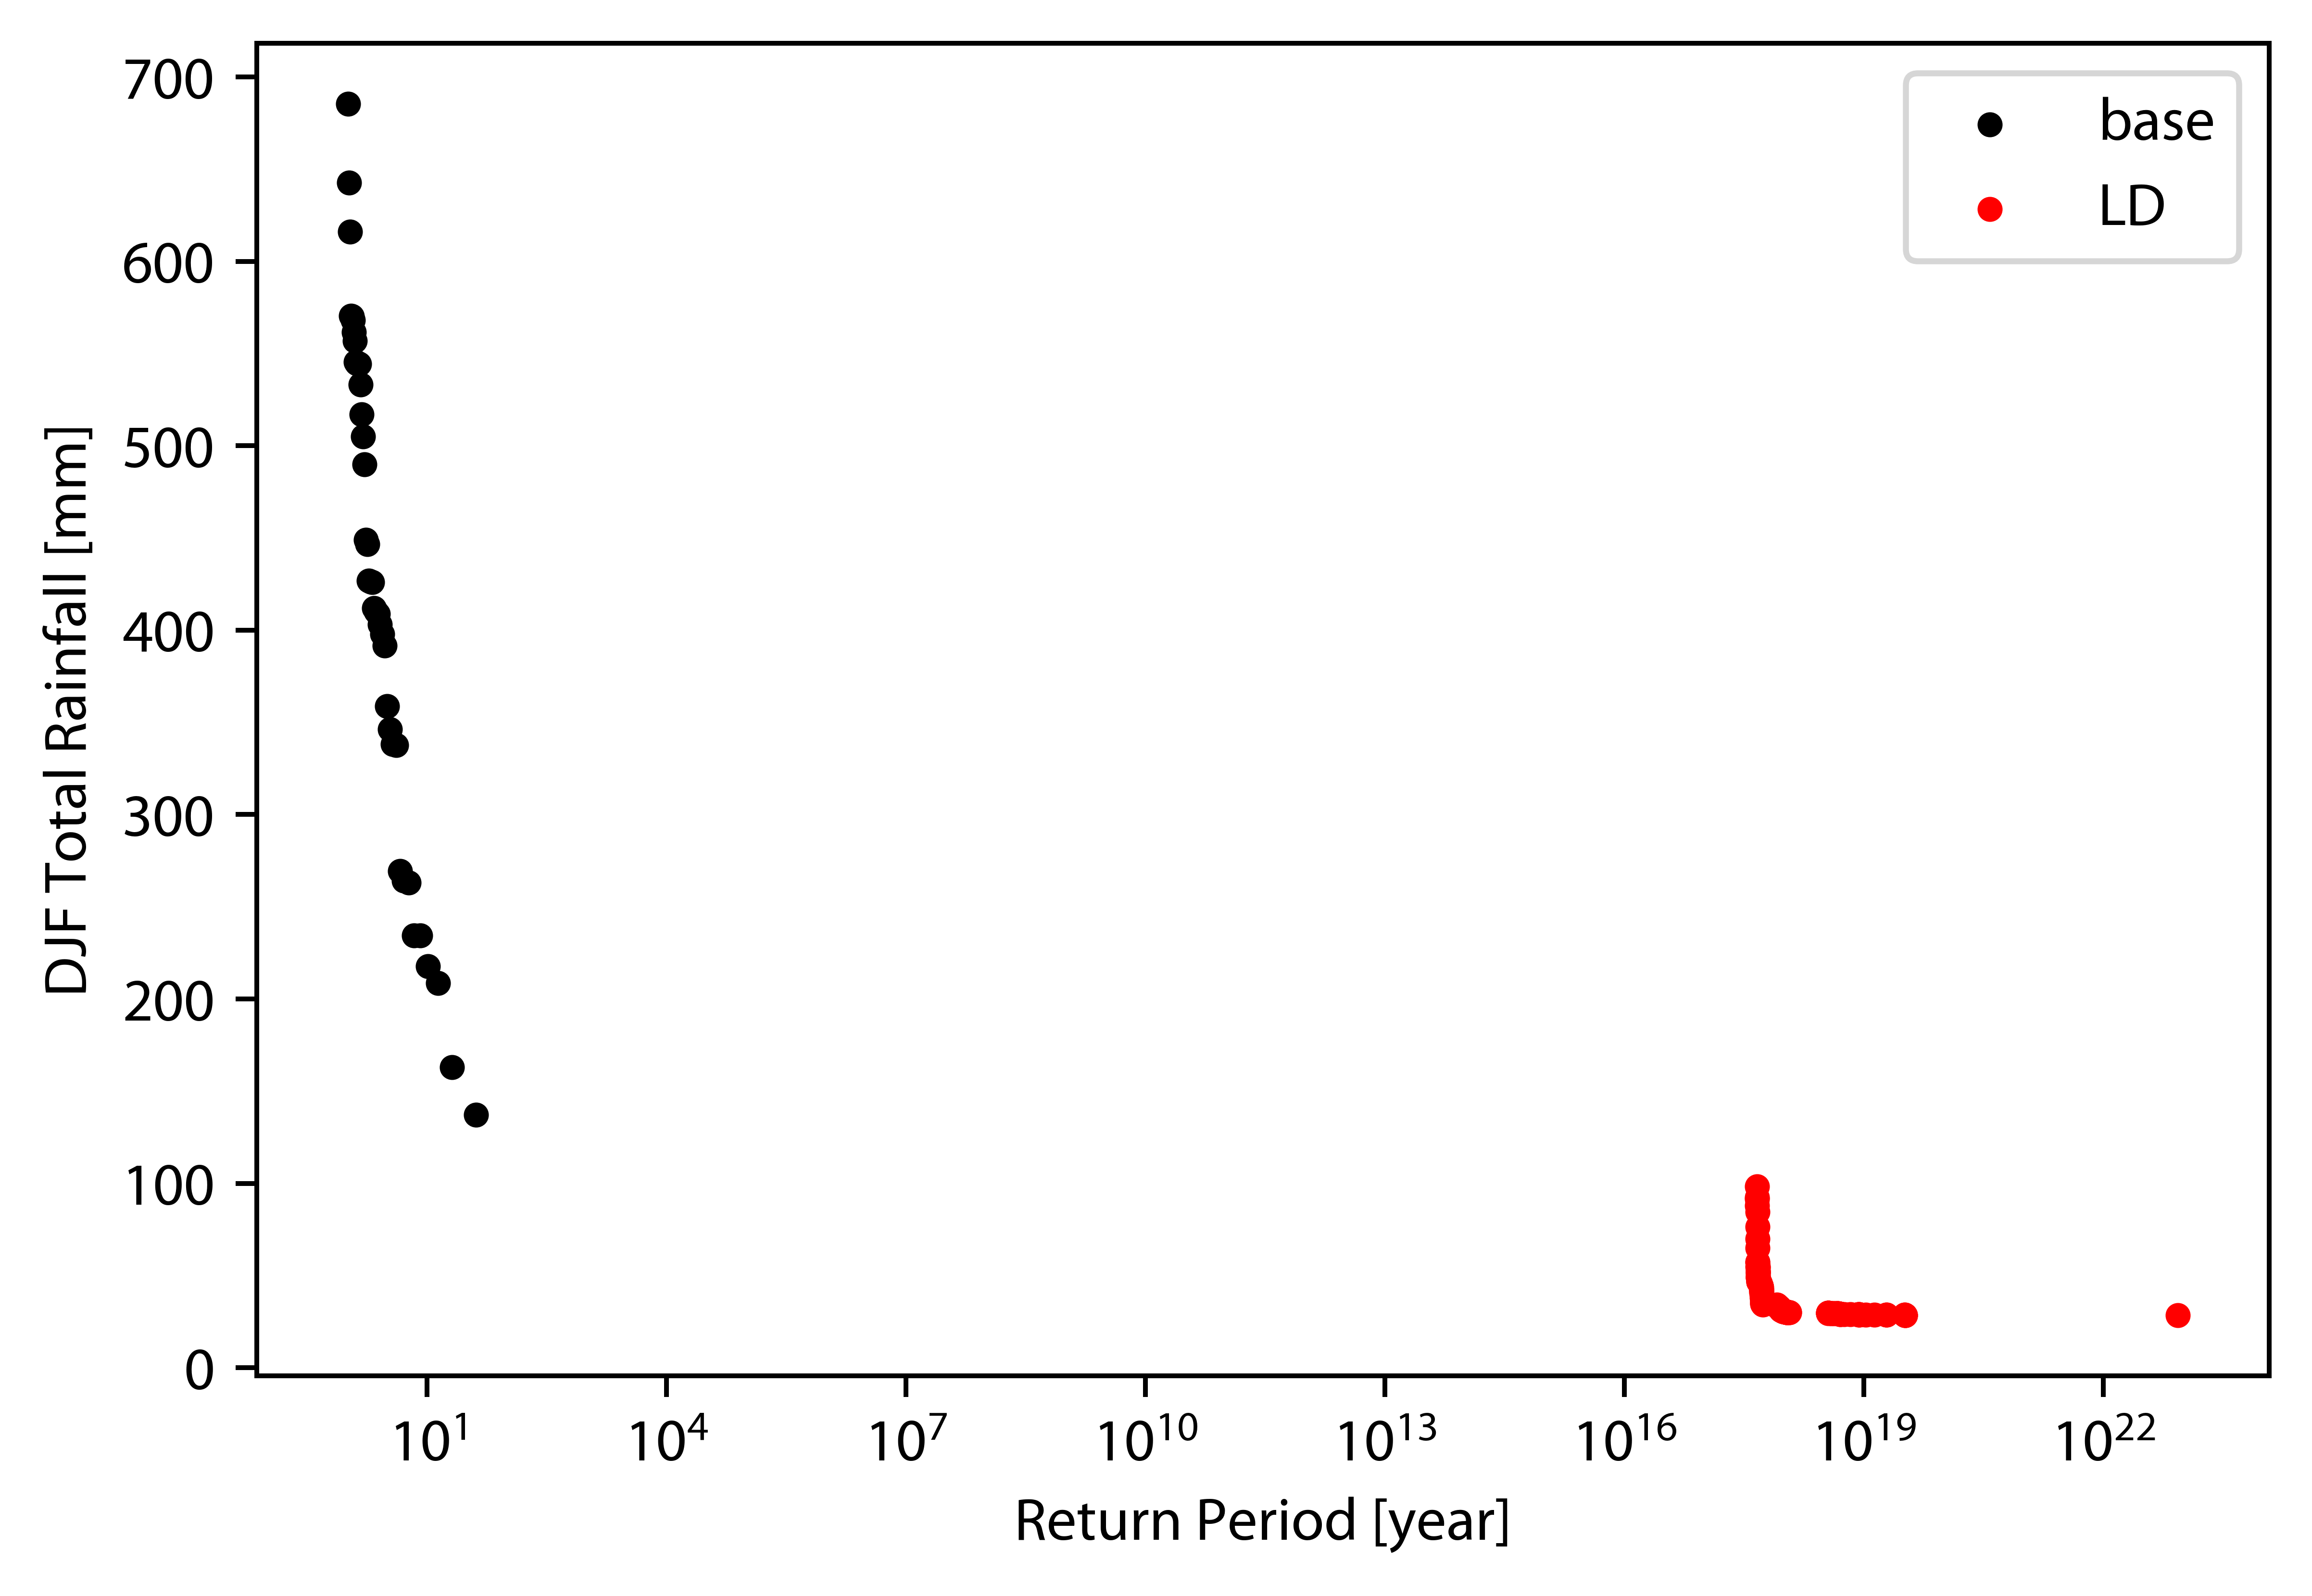

In [4]:
base_rain = np.loadtxt('rain_djftot_2061-2100.txt')
base_rain = sorted(base_rain[60, :])
# outlier1 = base_rain[0]
# base_rain = base_rain[1:]

ecdf = (np.arange(1, len(base_rain) + 1))/ (len(base_rain) + 1)
erp = 1 / ecdf
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.scatter(erp, base_rain, marker='o', color='black', s=10, label='base')
ax.scatter(tmp.rp, [tmp.rank[i][1] for i in range(len(tmp.rank))], marker='o', color='red', s=10, label='LD')
# ax.axline([0, outlier1], [1, outlier1], color='black', linestyle='--', label='outlier 1', linewidth=0.5)
ax.set_xlabel('Return Period [year]')
ax.set_ylabel('DJF Total Rainfall [mm]')
# ax.set_ylim([0, 600])
ax.set_xscale('log')
ax.legend()

In [17]:
traj = np.nanmean(np.multiply(tmp.rain_order, tmp.mask), axis=(2,3))
base_rain = np.loadtxt('rain_djftot_2061-2100.txt').T
rep_idx = list(range(4, 80, 4))
traj = np.delete(traj, rep_idx, axis=1)
print(base_rain.shape, traj.shape)


(40, 91) (128, 61)


In [18]:
traj[0, :]

array([ 0.        ,  0.03685161,  0.03696328,  5.04736325,  5.17233412,
        5.1981115 ,  5.43539467,  6.56565117,  6.59495196,  6.59849644,
       21.29143242, 21.32155093, 21.44516964, 21.91900533, 21.91920742,
       21.92197508, 21.93944559, 22.24146188, 22.30896785, 23.4547356 ,
       24.05219905, 24.14129581, 24.80052955, 24.89002528, 25.19914157,
       25.49433784, 25.5017856 , 25.50414356, 25.61438247, 25.63883009,
       25.68388404, 25.71388972, 25.7383956 , 25.77034152, 26.19880633,
       26.19880663, 26.315507  , 26.58420362, 26.84328005, 26.84540807,
       27.2570624 , 27.4141764 , 27.41417885, 27.58656818, 27.58656818,
       27.58660684, 27.58811581, 27.62370213, 27.6943584 , 27.88359726,
       27.8922525 , 27.89628598, 28.49173569, 28.60185052, 28.60204307,
       28.62048109, 28.62048792, 28.6240683 , 28.67982579, 28.70202989,
       28.7928327 ])

Text(0, 0.5, 'Accumulated Rainfall [mm]')

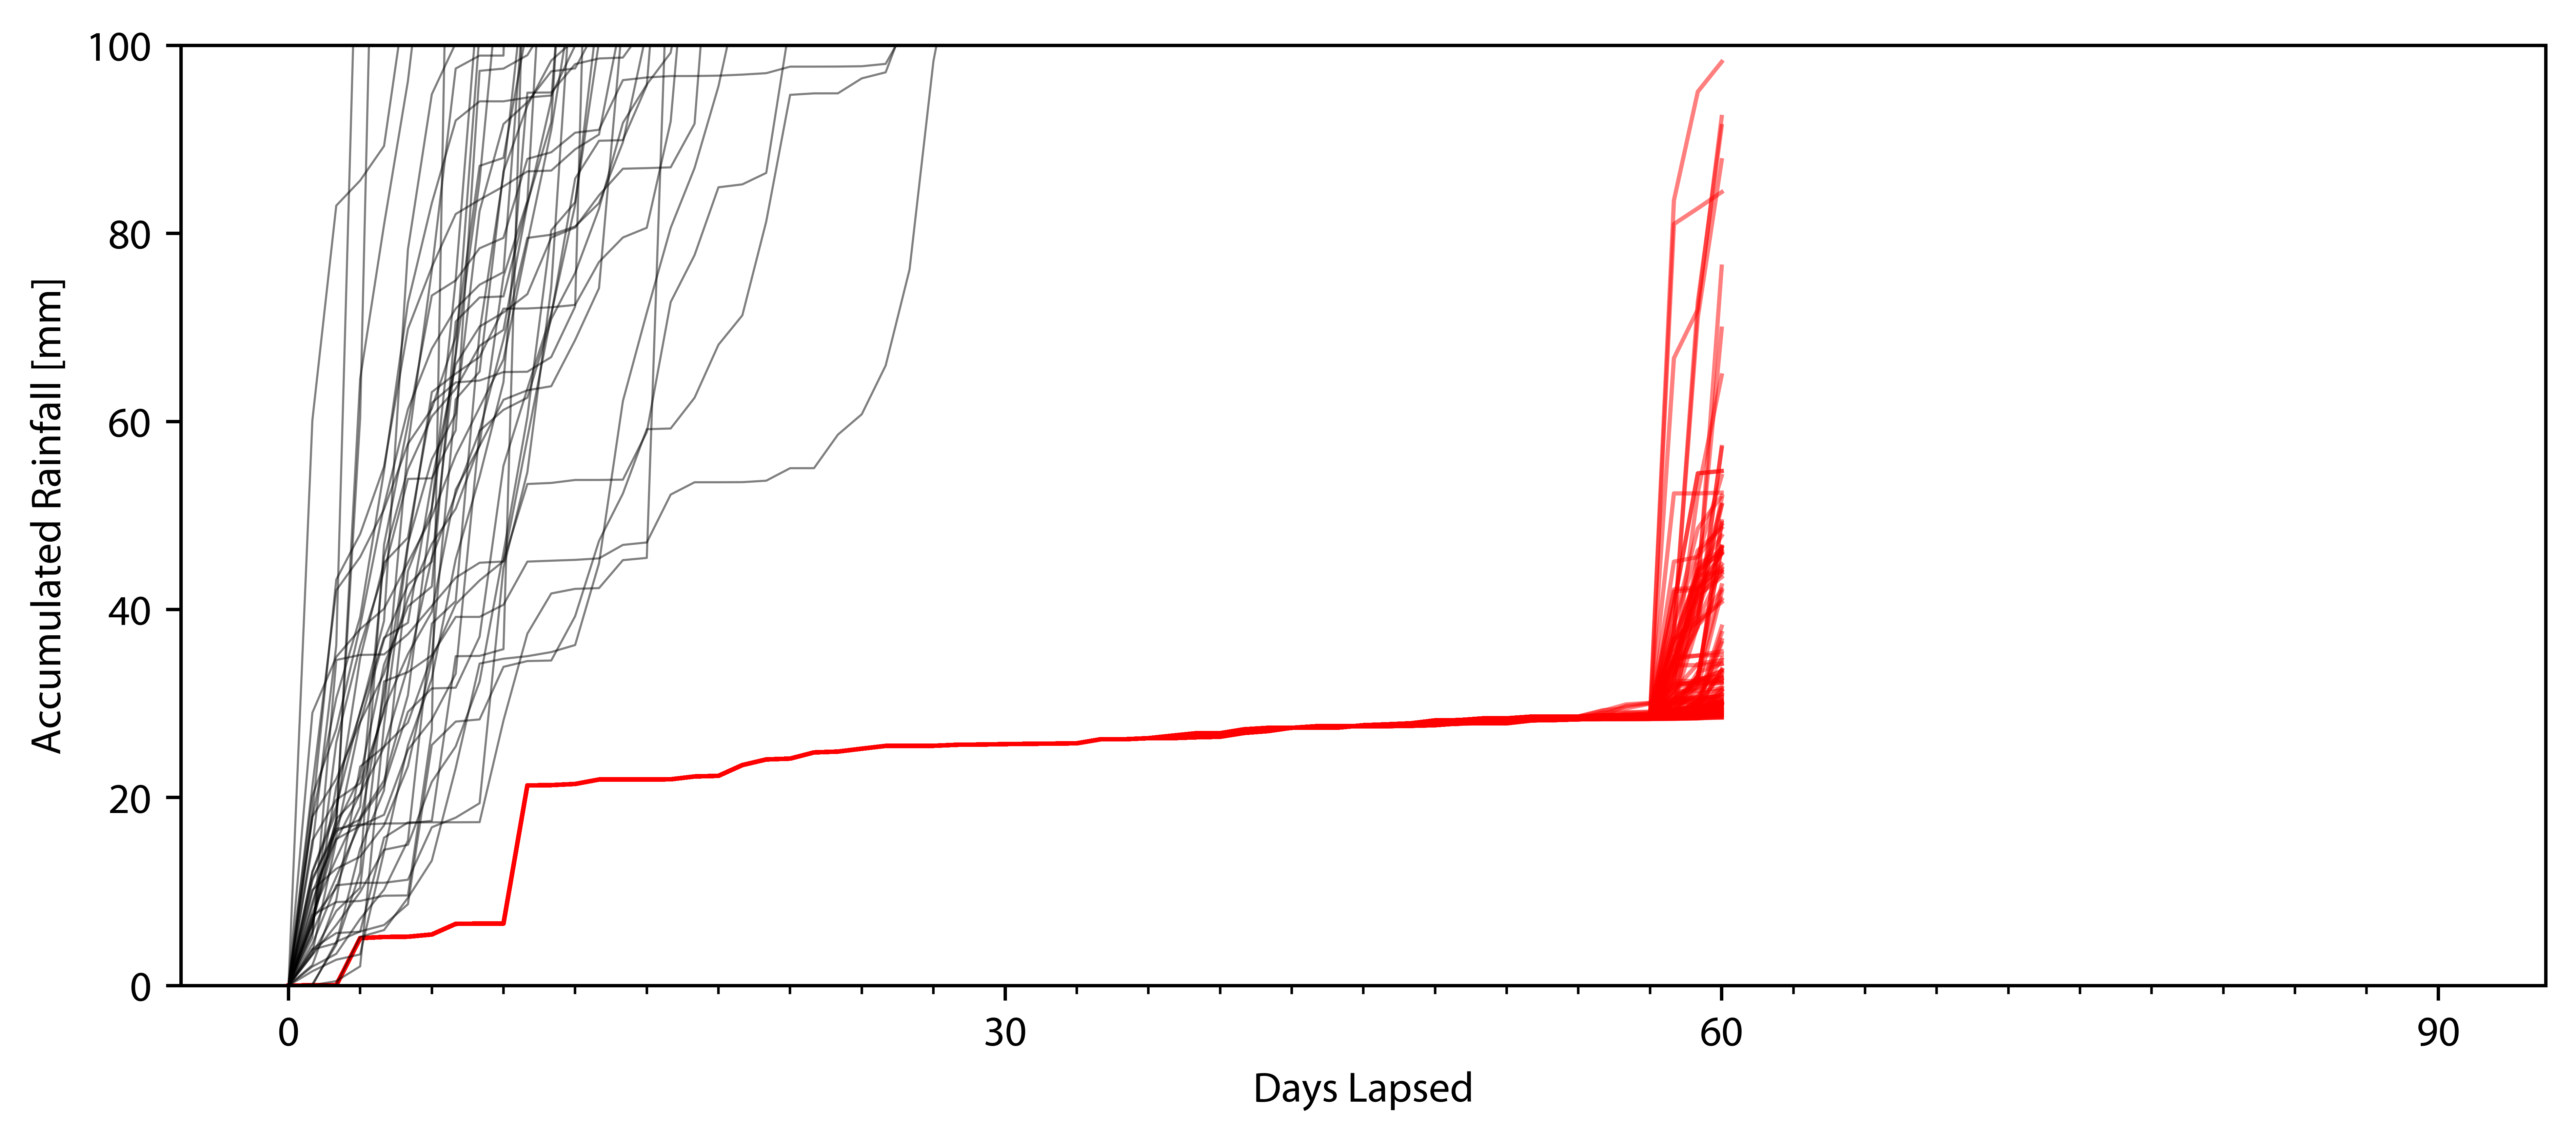

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(traj.T, color='red', alpha=0.5, linewidth=1)
ax.plot(base_rain.T, color='black', alpha=0.5, linewidth=0.5)
# the x range is 90 days (3 months)
# major xticks every 30 days
# minor xticks every 3 days
ax.set_ylim([0, 100])
ax.set_xticks(np.arange(0, 91, 30))
ax.set_xticks(np.arange(0, 91, 3), minor=True)
ax.set_xlabel('Days Lapsed')
ax.set_ylabel('Accumulated Rainfall [mm]')

In [8]:
base_rain = np.loadtxt('rain_djftot_2061-2100.txt').T
traj_raw = np.nanmean(np.multiply(tmp.rain_raw, tmp.mask), axis=(2,3))
print(base_rain.shape, traj_raw.shape)

(40, 91) (128, 80)


In [9]:
bc = tmp.bc_record // 3 
delta = {'dec': [], 'jan': [], 'feb': []}
key = ['dec', 'jan', 'feb']
for m in range(2):
    for i in range(10):
        ld_ts, ld_te = 40*m + 4*i, 40*m + 4*i + 3 
        base_ts, base_te = 30*m + 3*i, 30*m + 3*(i+1)
        for j in range(128):
            ld_delta = traj_raw[j, ld_te] - traj_raw[j, ld_ts]
            if ld_delta < 0:
                print((m*10+i, j))
            tmp_bc = bc[j, 10*m + i]
            # print(tmp_bc)
            base_delta = base_rain[tmp_bc, base_te] - base_rain[tmp_bc, base_ts]
            delta[key[m]].append((base_delta, ld_delta))

         

IndexError: list index out of range

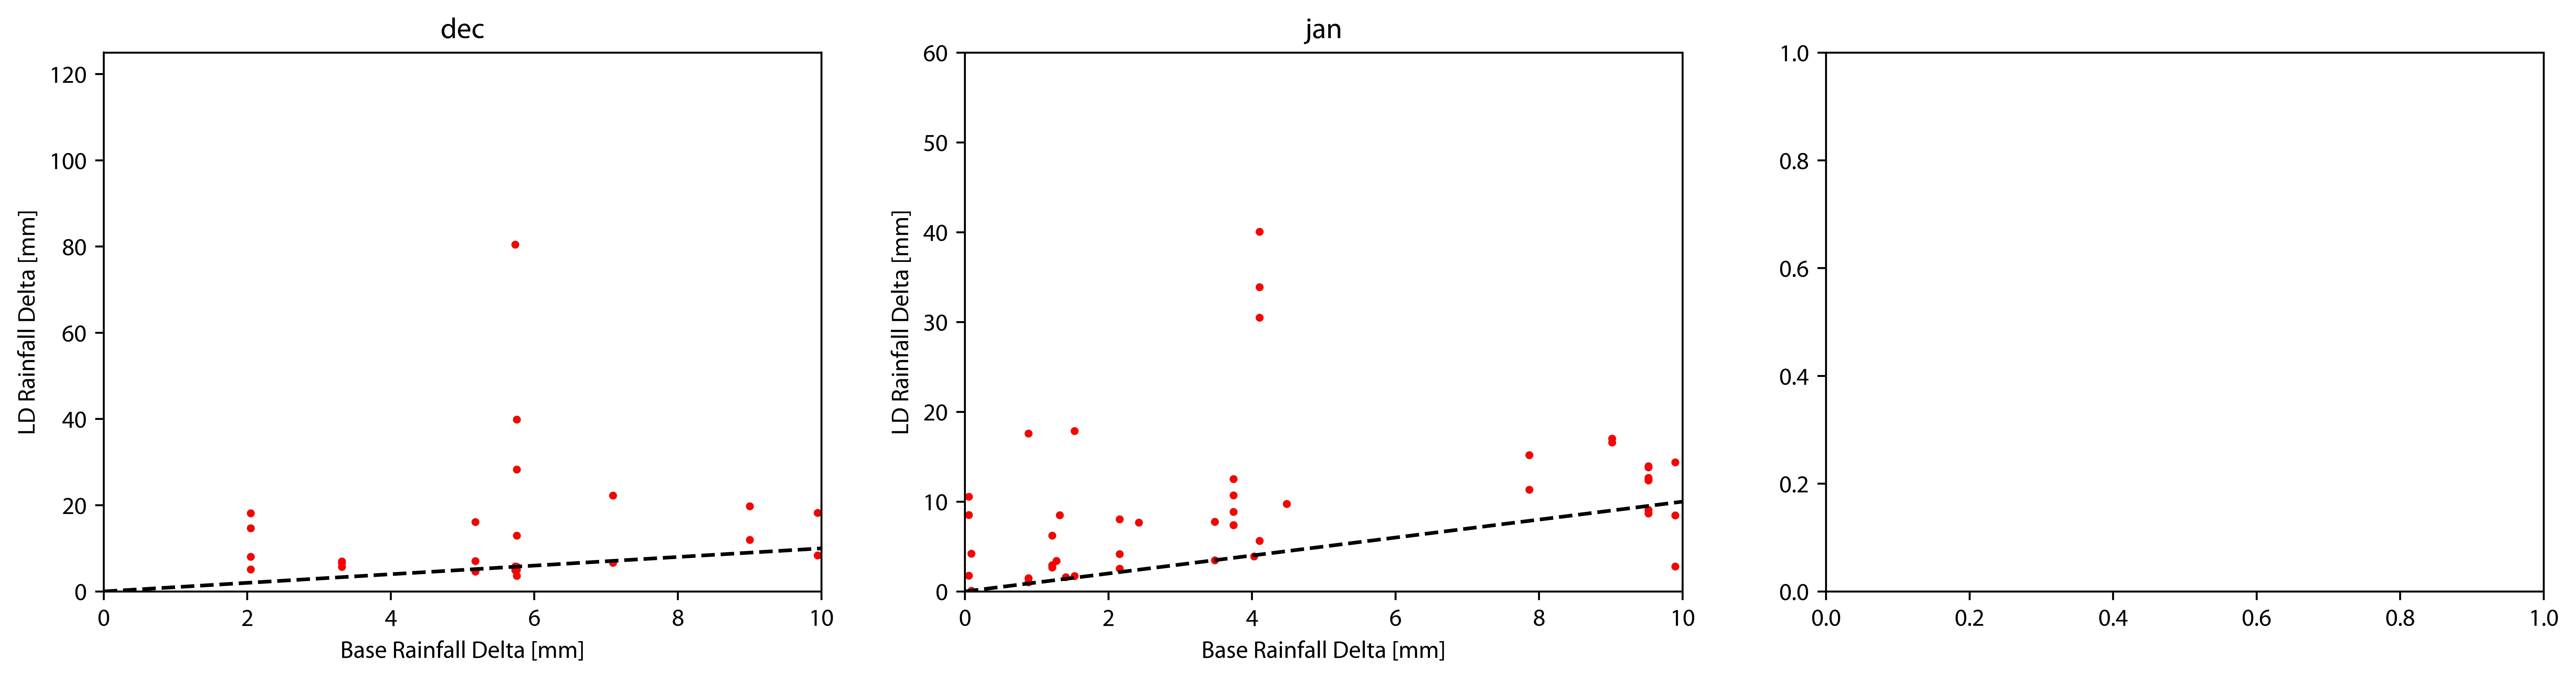

In [10]:
fig, ax = plt.subplots(1, 3, figsize = (18, 4))
tmpmax = [125, 60, 30]
for i in range(3):
    ax[i].scatter([delta[key[i]][j][0] for j in range(128)], [delta[key[i]][j][1] for j in range(128)], color='red', s=5)
    ax[i].axline([0, 0], [1, 1], color='black', linestyle='--')
    ax[i].set_xlabel('Base Rainfall Delta [mm]')
    ax[i].set_ylabel('LD Rainfall Delta [mm]')
    ax[i].set_title(key[i])
    ax[i].set_xlim(0, 10)
    ax[i].set_ylim(0, tmpmax[i])

In [11]:

for m in range(2):
    for i in range(10):
        ld_ts, ld_te = 40*m + 4*i, 40*m + 4*i + 3 
        base_ts, base_te = 30*m + 3*i, 30*m + 3*(i+1)
        tmp_ld = []
        tmp_base = []
        for j in range(128):
            ld_delta = traj_raw[j, ld_te] - traj_raw[j, ld_ts]
            tmp_ld.append(ld_delta)
        for j in range(40):
            base_delta = base_rain[j, base_te] - base_rain[j, base_ts]
            tmp_base.append(base_delta)
        tmp_ld = np.array(tmp_ld)
        tmp_base = np.array(tmp_base)
        tmp_parent = tmp.parent[:, 10*m + i + 1]
        cc = collections.Counter(tmp_parent)
        sel_idx = [i for i in cc.keys() if cc[i] > 1]
        pause = 1

Text(0.5, 0, 'weights')

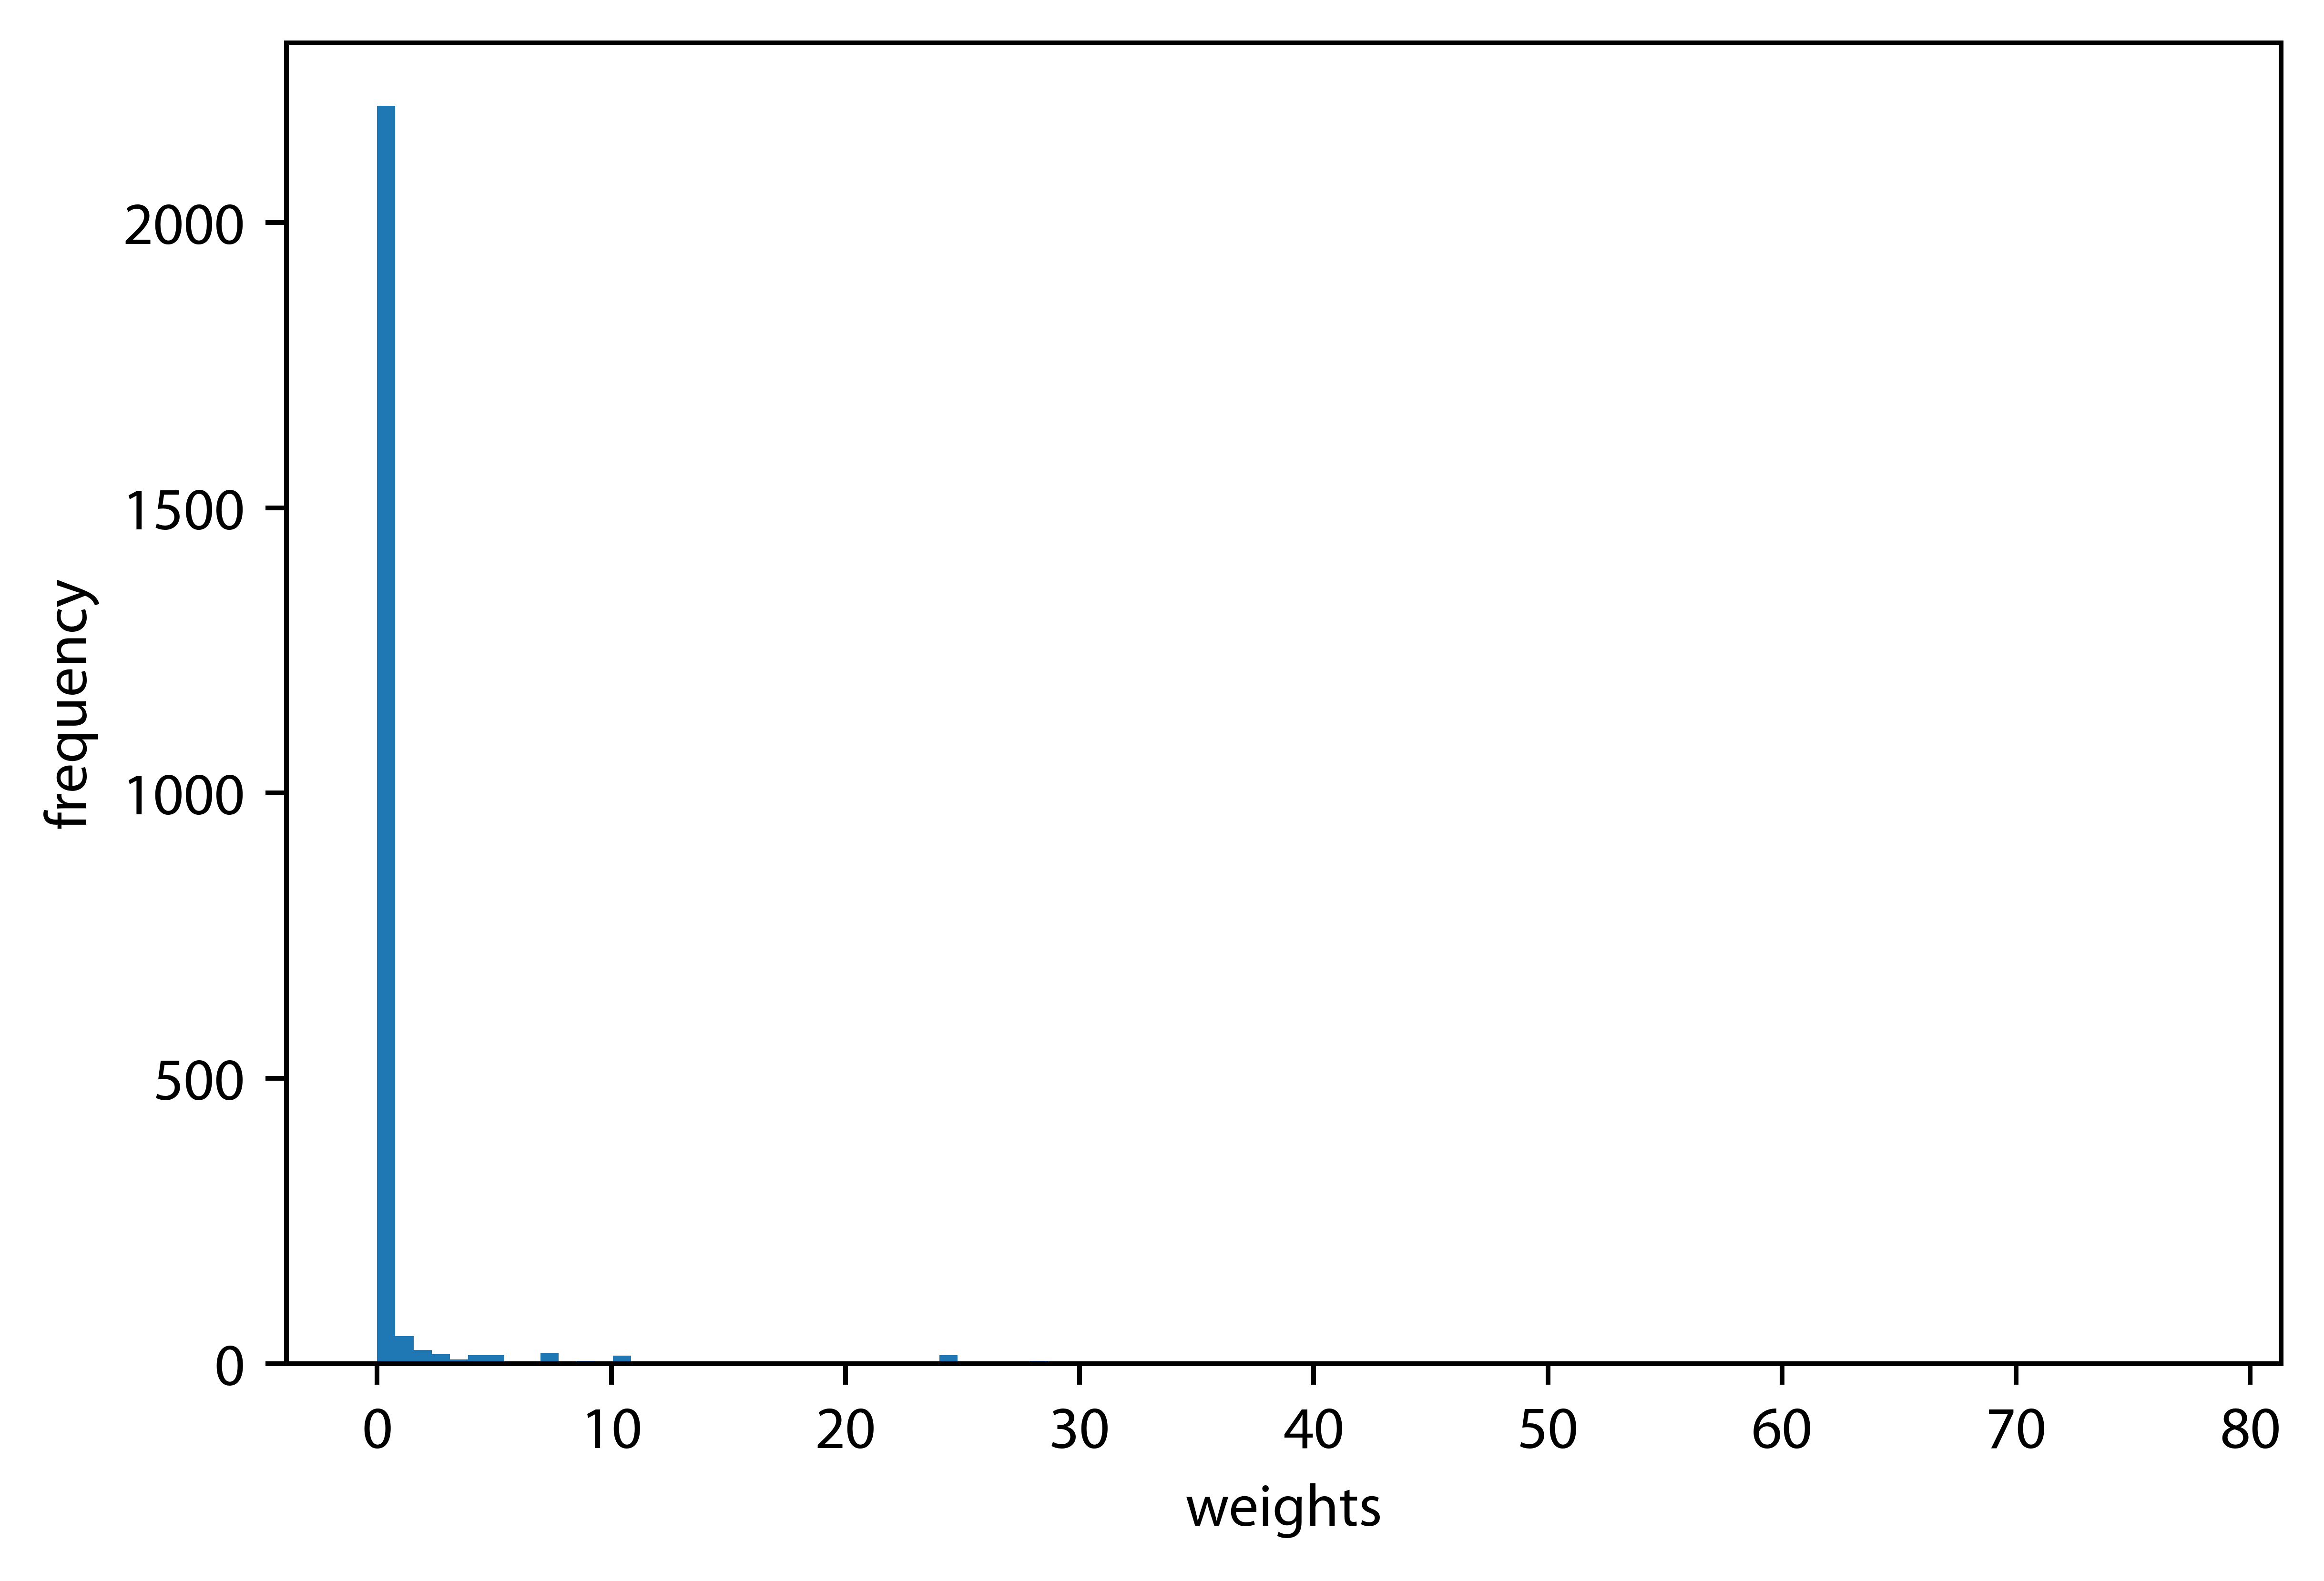

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.hist(tmp.weight_[:, :-1].flatten(), bins=100)
ax.set_ylabel('frequency')
ax.set_xlabel('weights')

Text(0.5, 0, 'weights')

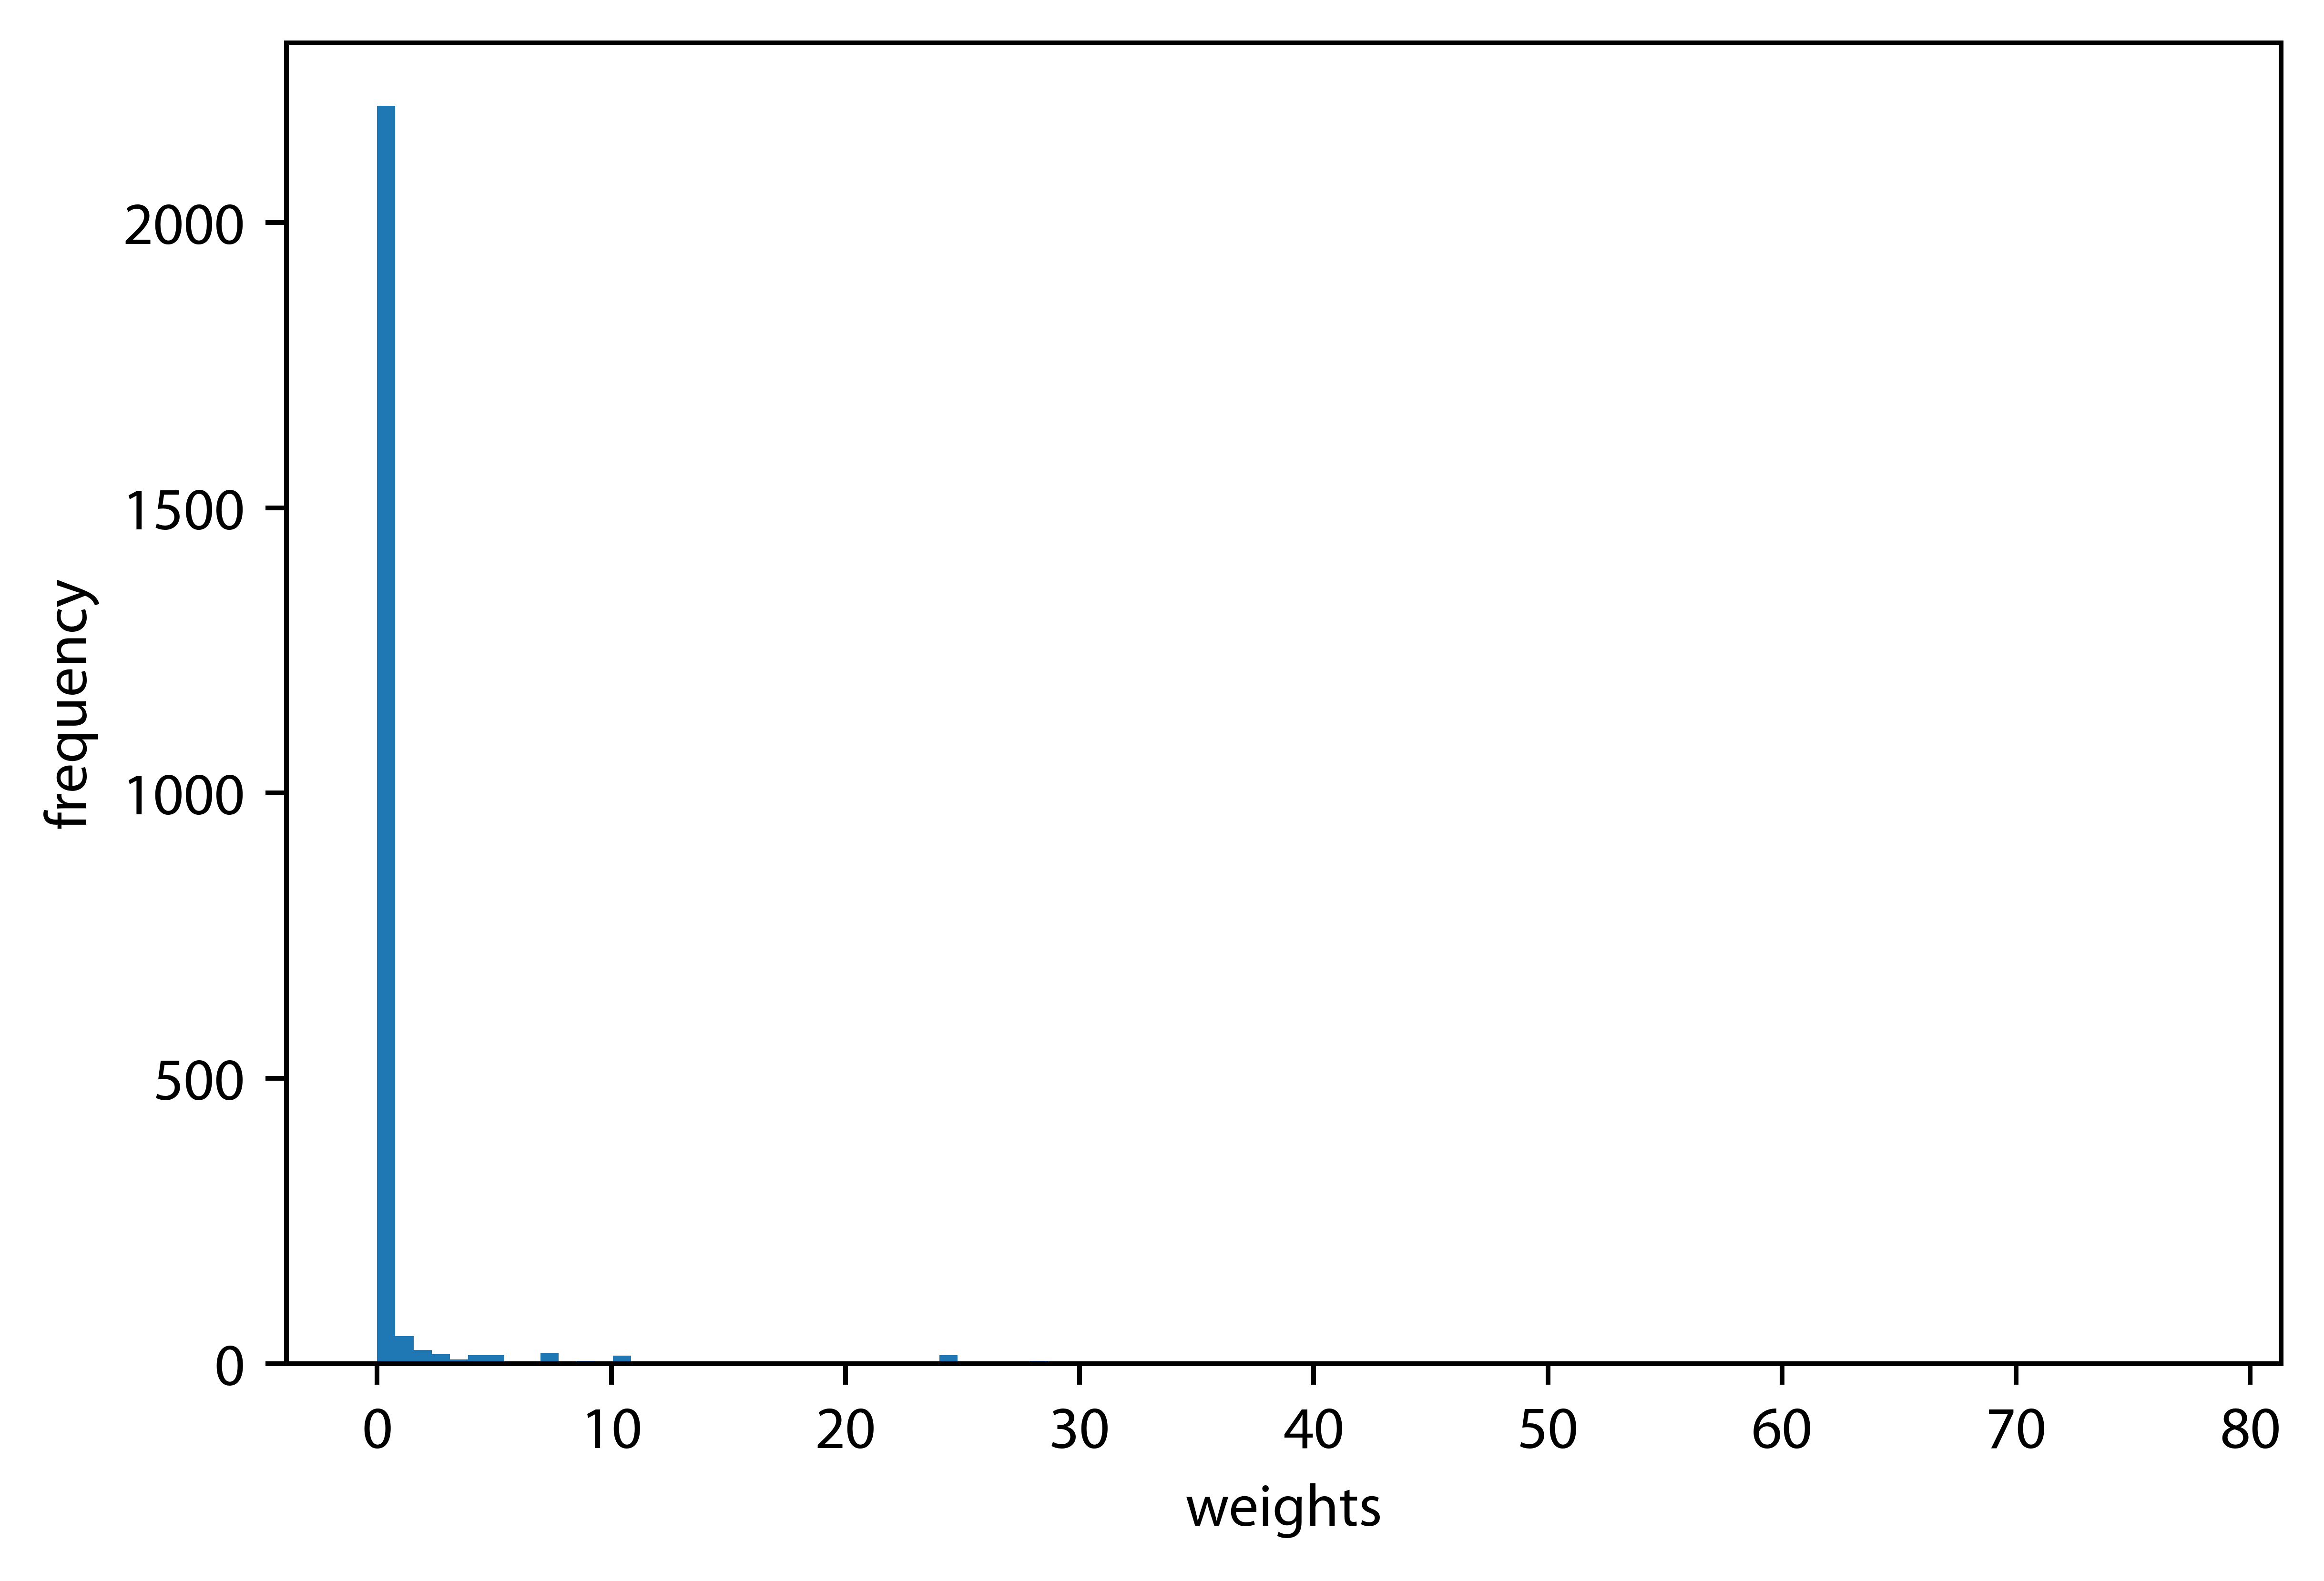

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.hist(tmp.weight_[:, :-1].flatten(), bins=100)
ax.set_ylabel('frequency')
ax.set_xlabel('weights')

In [14]:
np.max(tmp.weight_[:, :-1].flatten())

77.44823468674358